In [26]:
import numpy as np
np.warnings.filterwarnings('ignore')
import scipy.io as sio
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic, pearsonr
from pyearth import Earth, export
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "/Users/xizheng/Documents/florin/respiration/K1/K1_20191226_r0_traces.mat"
Traces = sio.loadmat(filepath)['Traces']

In [3]:
def process_resp(resp):
    windowsize = 15
    resp = resp - np.median(resp)
    resp = -resp
    resp = np.convolve(resp, np.ones(windowsize), 'same') / windowsize
    resp_pks_2, _ = find_peaks(-resp, prominence=0.3, height=0.2, distance=10)
    
    return resp, resp_pks_2

In [35]:
move = []
d_to_target = []

for idx in range(Traces[0,0]['Trial'].shape[1]):
# for idx in range(2):
    
#     print("start analyzing", idx)
    # get data
    resp = Traces[0,0]['Sniffs'][0,idx].flatten()
    trial_on = Traces[0,0]['Trial'][0,idx].flatten()!=0
    if len(resp) == 0:
        print("skipping trial", idx)
        continue
    
    # select region to study
#     trial_off_idx = np.where(trial_on!=0)[0][-1]+1
    trial_off_idx = len(trial_on)
    trial_on = trial_on[:trial_off_idx]
    
    # resp
    resp, resp_pks_2 = process_resp(resp[:trial_off_idx])
    resp_signal = np.zeros(len(resp))
    resp_signal[resp_pks_2] = 1
    
    # lever
    lever = Traces[0,0]['Lever'][0,idx].flatten()
    lever = savgol_filter(lever, 25, 4)
    lever = lever[:trial_off_idx]
    
    pks1, _ = find_peaks(lever, prominence=0.01, distance=5)
    pks2, _ = find_peaks(-lever, prominence=0.01, distance=5)
    peaks = np.concatenate((pks1, pks2))
    peaks = np.sort(peaks)
    
    movement = np.zeros(len(peaks)-1)
    for i in range(len(peaks)-1):
        movement[i] = abs(lever[peaks[i+1]] - lever[peaks[i]])
    movement_signal = np.zeros(len(lever))
    movement_signal[peaks[:-1]] = movement
    large_threshold = 1
    
    # motor
    motor = Traces[0,0]['Motor'][0,idx].flatten()
    distance_to_target = np.maximum(np.abs(motor), 0)
    
    for start_idx in range(len(peaks)-1):
        if trial_on[peaks[start_idx]] != 0 and movement_signal[peaks[start_idx]] > large_threshold:
            move.append(movement_signal[peaks[start_idx]])
            d_to_target.append(distance_to_target[peaks[start_idx]])

skipping trial 0
skipping trial 56


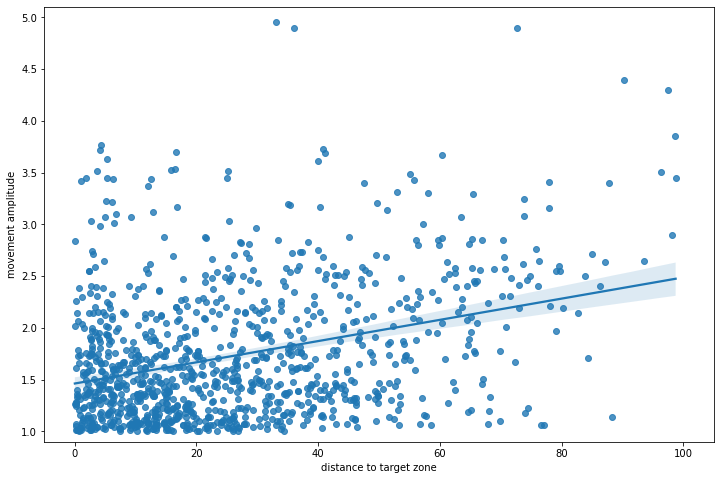

(0.33393644149854856, 4.438650994256952e-29)


In [36]:
plt.figure(figsize=(12,8))
sns.regplot(d_to_target, move)
plt.xlabel("distance to target zone")
plt.ylabel("movement amplitude")
plt.ylim((0.9,5.1))
plt.xlim((-5,105))
plt.show()

print(pearsonr(d_to_target, move))